Using the person's resume, we will try to predict what the education level is of the person. We will explore 2 approaches: (1) a bag-of-words model then using random forest classifier and (2) a bag-of-words model then applying a simple neural network.

In [50]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [51]:
df = pd.read_csv("./../assets/data_large_clean.csv", index_col = 0)

Let's explore how our data is distributed.

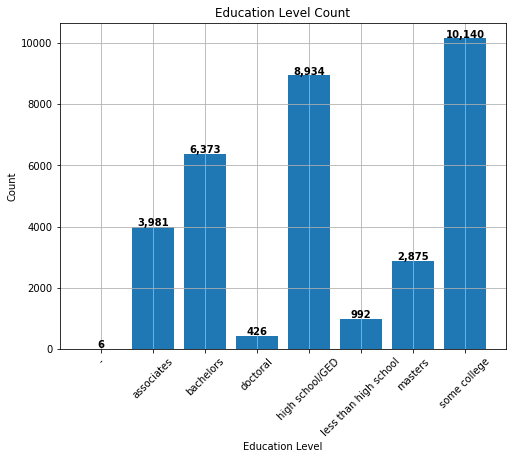

In [70]:
def plot_df():
    x = []
    y = []

    educ_count = df.groupby(['education']).count()['city']
    educ_list = list(sorted(df['education'].unique()))

    for educ in educ_list:
        x.append(educ)
        y.append(educ_count[educ])

    plt.figure(figsize = (8,6))
    plt.title("Education Level Count")
    plt.xlabel("Education Level")
    plt.ylabel("Count")
    plt.grid()
    plt.xticks(rotation=45)

    for idx, value in enumerate(y):
        plt.text(x = idx, y = value + 35, 
                 s = f"{value:,}", fontweight='bold', 
                 horizontalalignment='center')

    plt.bar(x, y);
    
plot_df()

Machine learning models are very sensitive to imbalanced data. For an exaggerated example, imagine training a model to predict dogs and cats. If your training data has 99 images of dogs and only 1 image of a cat, your model will most likely overfit and only predict dogs and still get 99% accuracy.

We will filter and clean our data in preparation for the prediction and become a data janitor.

With our data collection process, some of the posts were repeated. They were either posted in different times or different locations. We'll take a look at all data points that aren't unique in the `clean_content` column.

In [73]:
df[df.duplicated(subset = 'clean_content')].head(10)

,city,searched_zipcode,url,content,posting_date,education,n_photos,availability,region,type of employment,clean_content
10,ElPaso,79936,https://elpaso.craigslist.org/res/d/looking-fo...,I DO BEST RESUMES IN TOWN.\n\nI AM TECHNICAL W...,2019-07-25 10:12,bachelors,0,"['afternoons', 'evenings', 'mornings', 'weekda...",elpaso,looking-for-new-career-move-you-need,i do best resumes in town.. i am technical wri...
11,ElPaso,79936,https://elpaso.craigslist.org/res/d/you-tired-...,I DO BEST RESUMES IN TOWN.\n\nI AM TECHNICAL W...,2019-07-25 10:08,bachelors,0,"['evenings', 'mornings', 'overnight']",elpaso,you-tired-of-being-unemployed-aint-the,i do best resumes in town.. i am technical wri...
15,ElPaso,79936,https://elpaso.craigslist.org/res/d/you-tired-...,I DO BEST RESUMES IN TOWN.\n\nI AM TECHNICAL W...,2019-07-23 11:01,bachelors,0,"['afternoons', 'evenings', 'mornings', 'overni...",elpaso,you-tired-of-being-unemployed-aint-the,i do best resumes in town.. i am technical wri...
22,ElPaso,79936,https://elpaso.craigslist.org/res/d/massages/6...,Hello my name is Adrian I am 23 years old I am...,2019-08-10 12:15,high school/GED,1,['mornings'],elpaso,massages,hello my name is adrian i am 23 years old i am...
75,LosAngeles,90011,https://sandiego.craigslist.org/csd/res/d/medi...,"Hello,\nMy name is Ronnie I've been a MA for o...",2019-09-03 15:37,some college,3,"['afternoons', 'evenings', 'mornings', 'overni...",sandiego,medical-assistant,"hello,. my name is ronnie i've been a ma for o..."
76,LosAngeles,90011,https://sandiego.craigslist.org/csd/res/d/medi...,"Hello,\nMy name is Ronnie I've been a MA for o...",2019-09-03 15:39,some college,2,"['afternoons', 'evenings', 'mornings', 'overni...",sandiego,medical-assistant,"hello,. my name is ronnie i've been a ma for o..."
77,LosAngeles,90011,https://sandiego.craigslist.org/csd/res/d/medi...,"Hello,\nMy name is Ronnie I've been a MA for o...",2019-09-03 15:38,some college,3,"['afternoons', 'evenings', 'mornings', 'overni...",sandiego,medical-assistant,"hello,. my name is ronnie i've been a ma for o..."
82,LosAngeles,90011,https://losangeles.craigslist.org/lac/res/d/it...,I'm an independent contractor in IT industry s...,2019-08-23 17:17,bachelors,0,"['afternoons', 'evenings', 'mornings', 'overni...",losangeles,it-tech-is-looking-for-project-an,i'm an independent contractor in it industry s...
88,LosAngeles,90011,https://sandiego.craigslist.org/esd/res/d/real...,"Hello, my name is Andres Alvarado. I am an art...",2019-09-05 16:10,high school/GED,2,"['afternoons', 'evenings', 'mornings']",sandiego,real-professional-individual,"hello, my name is andres alvarado. i am an art..."
104,LosAngeles,90011,https://losangeles.craigslist.org/sgv/res/d/se...,I am low voltage tech with experience in secur...,2019-08-12 16:21,some college,5,"['afternoons', 'evenings', 'mornings', 'overni...",losangeles,security-and-alarm-tech-looking-for,i am low voltage tech with experience in secur...


Notice that some of the data points were posted at different times or region. However, we only need one instance of that data.

In [79]:
df.drop_duplicates(subset = 'clean_content', keep = 'first', inplace = True)
df.reset_index(drop = True, inplace = True)

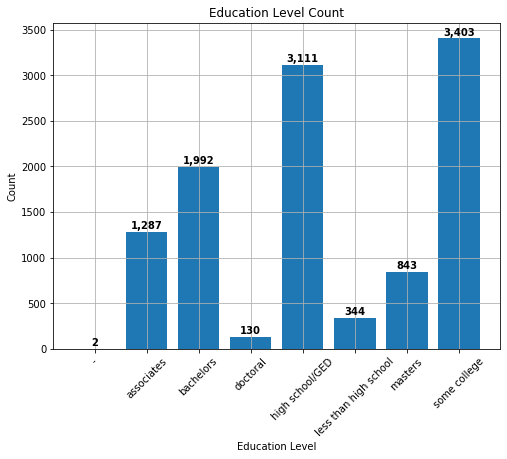

In [82]:
plot_df()

We reduced the amount of data tha we have to about 1/3. We notice that some of the labels only have a few data points. There are several ways to address imbalance datasets such as upsampling or downsampling. However for this exercise, we will only use labels that have at least 500 samples.

In [91]:
# List out education levels that we will include
included_educ_level = ['high school/GED',
                       'some college',
                       'associates',
                       'bachelors',
                       'masters']

# Filter out our data and only include samples that are in the selected education levels
df = df[df['education'].isin(included_educ_level)].reset_index(drop = True)

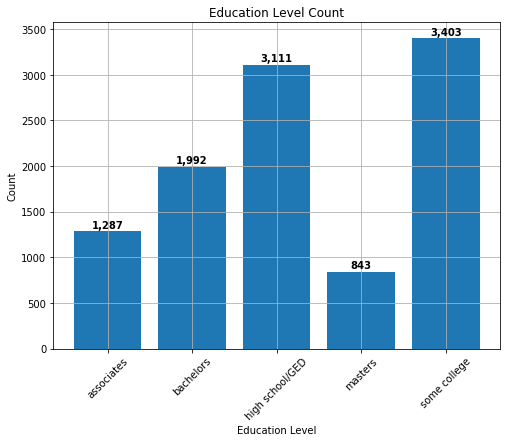

In [96]:
plot_df()

Now our data looks good and we can work on developing the classification model.

In [97]:
# We only need the clean_content and education
working_data = df[['clean_content', 'education']]

In [98]:
working_data

,clean_content,education
0,"aside from word of mouth or face to face , col...",some college
1,looking for a new job and no respond from the ...,bachelors
2,i do best resumes in town.. i am technical wri...,bachelors
3,well i'm a 24 year old female just lost my job...,some college
4,caregiver available immediately. 5 years hospi...,bachelors
...,...,...
10631,master’s degreed accountant looking for client...,masters
10632,hello i need to make extra cash for upcoming s...,high school/GED
10633,"swm 5'10"" and 160# blonde and hazel caregiver/...",some college
10634,hello. i am looking for an warehouse managemen...,some college


# Classification

In [297]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### Bag of Words

<img src="./../assets/images/bow-image.png" style="width: 300px;">

A bag-of-words model puts every word in your document into a bag (vector) and returns the bag. The most common bag of words model is the count vectorizer where you count each occurence of a word in a document. The visual above represents the count vectorizer. It's easy to use however this removes the sentence structure of the document.


In [377]:
vector = CountVectorizer(analyzer = 'word',
                         stop_words = 'english',
                         max_features = 10000)

features = vector.fit_transform(df_sub['clean_content'])

### One Hot Encoding
Our data contains multiple classes. Our first intuition would be to label each class by number such as 0 - high school/GED, 1 - some college, and 2 - bachelors. However, this doesn't correctly translate to numerical values. The average of 0 and 2 is 1 but the average of bachelors and highschool/GED isn't some college. The solution to this problem is called `one hot encoding` where you assign a value 1 to the feature that matches your data.

In [191]:
encoder = LabelEncoder()
target = encoder.fit_transform(working_data['education'])

target = pd.DataFrame({'education':working_data['education'].values,
                       'target':target})
target.sample(10)

,education,target
9172,high school/GED,2
8056,high school/GED,2
4164,high school/GED,2
3994,high school/GED,2
8680,bachelors,1
10456,bachelors,1
2127,some college,4
8389,some college,4
4641,high school/GED,2
5226,high school/GED,2


In [159]:
encoder = LabelBinarizer()
target = encoder.fit_transform(working_data['education'])

target = pd.DataFrame(target)
target['education'] = working_data['education']
target = target[['education', 0, 1, 2, 3, 4]]
target.sample(10)

,education,0,1,2,3,4
1100,masters,0,0,0,1,0
6200,high school/GED,0,0,1,0,0
9546,associates,1,0,0,0,0
6794,high school/GED,0,0,1,0,0
932,some college,0,0,0,0,1
10233,some college,0,0,0,0,1
6915,some college,0,0,0,0,1
9173,associates,1,0,0,0,0
3889,some college,0,0,0,0,1
9939,bachelors,0,1,0,0,0


In [376]:
encoder = LabelEncoder()

target = encoder.fit_transform(df_sub['education'])
labels = list(encoder.classes_)

In [377]:
vector = CountVectorizer(analyzer = 'word',
                         stop_words = 'english',
                         max_features = 10000)

features = vector.fit_transform(df_sub['clean_content'])

In [378]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, shuffle = True)

In [379]:
clf = RandomForestClassifier(n_estimators = 100,
                             max_depth = 200,
                             min_samples_split = 10,
                             bootstrap = True)

In [380]:
clf.fit(X_train, y_train);

In [381]:
train_score = clf.score(X_train, y_train)
test_score  = clf.score(X_test, y_test)

print(f"Training score:\t{train_score*100:.2f}%")
print(f"Testing score:\t{test_score*100:.2f}%")

Training score:	98.59%
Testing score:	90.62%


In [382]:
sample_resume = "i have a masters degree in interior architecture & design. www.lifestylesaint.com the expertise in design i have is diverse, working on projects ranging from high end residential to hotels, hotel, pip's, commercial projects, offices, building facades, renovations, multifamily, etc. some past clients include starbucks, hampton inn, la quinta and residential rehabs. no matter the size of your project, i am ready to provide solutions at good price."
sample_resume = "cleaning driving driving driving"

In [386]:
def get_prediction(text):
    sample_vec = vector.transform([text])
    predict = clf.predict(sample_vec)
    print(predict)
    predict_class = encoder.inverse_transform(predict.astype(int))
    print(predict_class)
    
    print(text,"\n")
    print(f"Predict:\t{predict_class[0]}")

get_prediction(working_data['clean_content'].iloc[3])

[4]
['some college']
well i'm a 24 year old female just lost my job and my friend is 34 female and were both looking for work , can help with chores around the house , just need to make cash to pay bills let me know if there is anything i can help you with , thank you 

Predict:	some college


# Neural Network

In [387]:
import numpy as np

import torch
import torchvision

from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as utils

In [388]:
cuda = torch.cuda.is_available()

if cuda:
    print("GPU detected. Training with GPU")
else:
    print("No GPU detected. Training with CPU")

No GPU detected. Training with CPU


In [404]:
encoder = LabelEncoder()

target = encoder.fit_transform(df_sub['education'])
labels = list(encoder.classes_)

In [405]:
vector = CountVectorizer(analyzer = 'word',
                         stop_words = 'english',
                         max_features = 10000)

features = vector.fit_transform(df_sub['clean_content'])

In [406]:
tensor_X = torch.stack([torch.Tensor(row.todense()) for row in features])
tensor_y = torch.tensor(target)

In [407]:
dataset = utils.TensorDataset(tensor_X, tensor_y)
dataloader = utils.DataLoader(dataset, batch_size = 32,
                              shuffle = True)

In [408]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(10000, 2000)
        self.fc2 = nn.Linear(2000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100, 5)
        
        self.drop = nn.Dropout(0.25)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim = 1)
        
        return x

In [409]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

In [411]:
epochs = 10
if cuda:
    model = model.tocuda()
for e in range(epochs):
    running_loss = 0
    for text, labels in dataloader:
        if cuda:
            text = text.tocuda()
        log_ps = model(text)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(dataloader)}")

Training loss: 0.7740208445577929


KeyboardInterrupt: 

In [52]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def model_predict(text, model):
    text = vector.transform([text])
    text = torch.Tensor(text.todense())
    if cuda:
        model = model.tocuda()
        text = text.tocuda()
    predict = model(text)
    predict = predict.detach().numpy()[0]
    predict = softmax(predict)
    predict = predict.argmax()
    return predict

model_predict("I have a degree", model)

3

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes = (2000, 500, 100),
                    activation = 'relu',
                    solver = 'adam',
                    batch_size = 32,
                    learning_rate_init = 0.003,
                    max_iter = 5,
                    shuffle = True,
                    verbose = 1)

In [ ]:
mlp.fit(X_train, y_train)